# 多尺度目标检测

## 1. 多尺度锚框

为了演示如何在多个尺度下生成锚框，让我们先读取一张图像。 它的高度和宽度分别为561和728像素。

(275, 183, <matplotlib.image.AxesImage at 0x22307a1bb38>)

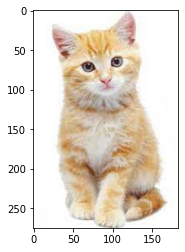

In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from d2l import torch as d2l

img = plt.imread('../img/cat1.jpg')
h, w = img.shape[:2]
h, w, plt.imshow(img)

display_anchors函数定义如下。 我们在特征图（fmap）上生成锚框（anchors），每个单位（像素）作为锚框的中心。 由于锚框中的(x, y)轴坐标值（anchors）已经被除以特征图（fmap）的宽度和高度，因此这些值介于0和1之间，表示特征图中锚框的相对位置。

In [2]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

首先，让我们考虑探测小目标。 为了在显示时更容易分辨，在这里具有不同中心的锚框不会重叠： 锚框的尺度设置为0.15，特征图的高度和宽度设置为4。 我们可以看到，图像上4行和4列的锚框的中心是均匀分布的。

d:\Anaconda3\envs\dl\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


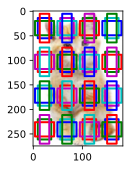

In [3]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

然后，我们将特征图的高度和宽度减小一半，然后使用较大的锚框来检测较大的目标。 当尺度设置为0.4时，一些锚框将彼此重叠。

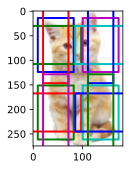

In [4]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

最后，我们进一步将特征图的高度和宽度减小一半，然后将锚框的尺度增加到0.8。 此时，锚框的中心即是图像的中心。

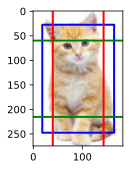

In [5]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

## 2. 多尺度检测

在多个尺度下，我们可以生成不同尺寸的锚框来检测不同尺寸的目标。

通过定义特征图的形状，我们可以决定任何图像上均匀采样的锚框的中心。

我们使用输入图像在某个感受野区域内的信息，来预测输入图像上与该区域位置相近的锚框类别和偏移量。

我们可以通过深入学习，在多个层次上的图像分层表示进行多尺度目标检测。